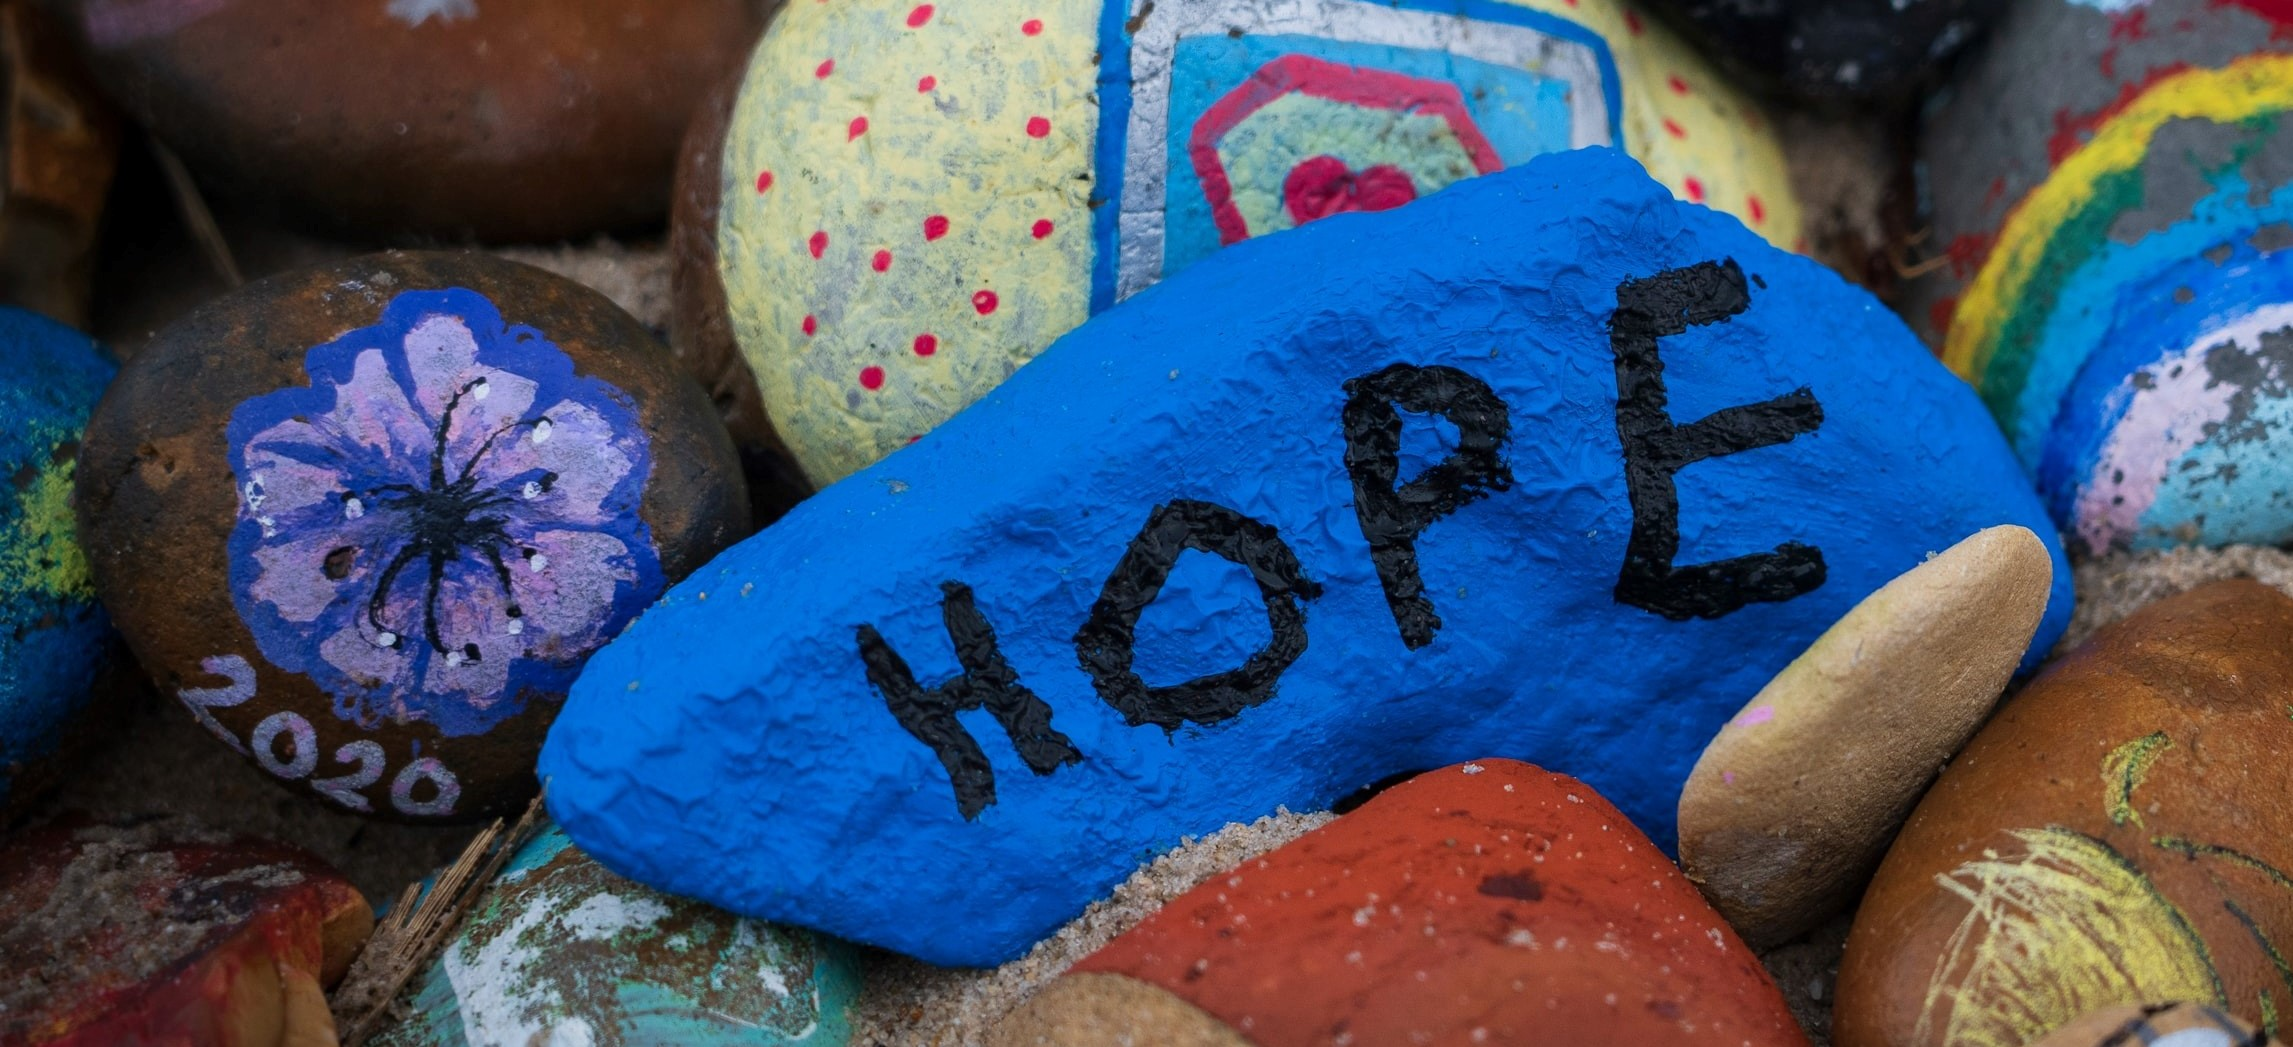

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,cross_val_score 
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from scipy import stats

#### Import the data

In [2]:
df = pd.read_csv('../input/breast-cancer-wisconsin-data/data.csv')

#### Examine first few rows

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### The dataset is mildly imbalanced

<AxesSubplot:xlabel='diagnosis', ylabel='count'>

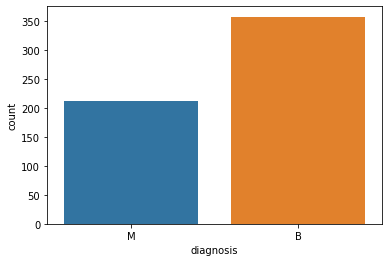

In [4]:
sns.countplot(x = df['diagnosis'])

#### No missing values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

#### Create a field to indicate malignant cases

In [6]:
list = [letter for letter in df.diagnosis == 'M']
df['Malignant'] = list
df = df.drop(columns = ['id','diagnosis'])

#### Let's look at correlations with malignancy

In [7]:
df.corr()['Malignant'].sort_values(ascending = False)

Malignant                  1.000000
concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
symmetry_se               -0

#### Drop some features with low correlation with the target

In [8]:
df = df.drop(columns = ['fractal_dimension_se','symmetry_se','texture_se','fractal_dimension_mean','smoothness_se','Unnamed: 32'])

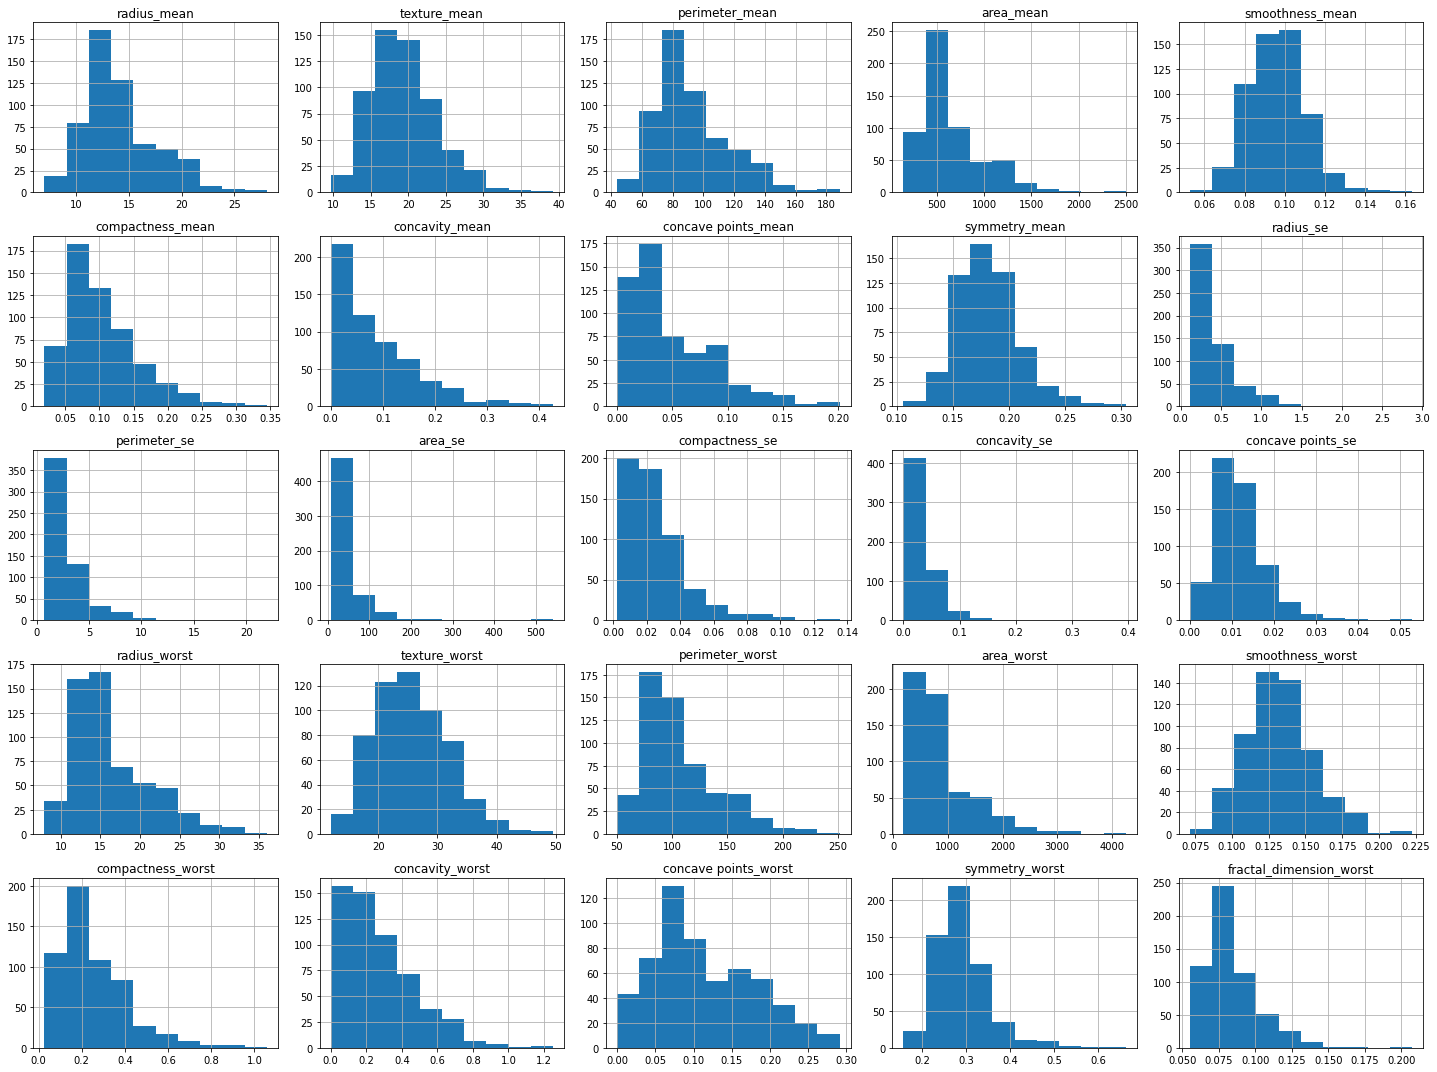

In [9]:
df.hist(figsize=(20,15))
plt.tight_layout()

#### Create X with the features and y the target

In [10]:
y = df['Malignant']
X = df.drop(columns = 'Malignant')

#### Create and fit the model

In [11]:
clf = RandomForestClassifier(n_estimators = 50, random_state = 73)
clf.fit(X,y)

RandomForestClassifier(n_estimators=50, random_state=73)

#### Use stratified cross validation to score the model

In [12]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

In [13]:
print(cross_val_score(clf, X, y, cv=skf, scoring='accuracy'))
print(cross_val_score(clf, X, y, cv=skf, scoring='accuracy').mean())

[0.93859649 0.95614035 0.99122807 0.97368421 0.96460177]
0.9648501785437045


#### A decent result but there are a large number of features.

In [14]:
print("Number of features = ", len(X.columns))

Number of features =  25


#### Can we pick out some key features without losing too much accuracy? Let's try using Mutual Information.

In [15]:
mutual_info = mutual_info_classif(X, y)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

perimeter_worst            0.475027
area_worst                 0.464235
radius_worst               0.454065
concave points_mean        0.438010
concave points_worst       0.437907
perimeter_mean             0.401872
concavity_mean             0.374534
radius_mean                0.369194
area_mean                  0.358559
area_se                    0.340613
concavity_worst            0.317686
perimeter_se               0.275873
radius_se                  0.249829
compactness_worst          0.225748
compactness_mean           0.213244
concave points_se          0.127339
texture_worst              0.121557
concavity_se               0.118615
texture_mean               0.097141
smoothness_worst           0.096081
symmetry_worst             0.088844
smoothness_mean            0.080793
compactness_se             0.075276
fractal_dimension_worst    0.071299
symmetry_mean              0.064112
dtype: float64

#### Let's pick the top 10 features

In [16]:
topfeatures = SelectKBest(mutual_info_classif, k=10)
topfeatures.fit(X, y)
features = X.columns[topfeatures.get_support()]
features

Index(['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean',
       'concave points_mean', 'area_se', 'radius_worst', 'perimeter_worst',
       'area_worst', 'concave points_worst'],
      dtype='object')

In [17]:
print(cross_val_score(clf, X[features], y, cv=skf, scoring='accuracy'))
print(cross_val_score(clf, X[features], y, cv=skf, scoring='accuracy').mean())

[0.90350877 0.92982456 0.98245614 0.95614035 0.96460177]
0.9473063188945815


#### Let's see how the model performs 

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X[features],y,random_state=123, stratify=y)
clf.fit(X_train, y_train)
clf.score(X_valid,y_valid)

0.951048951048951

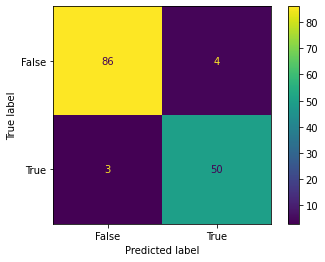

In [19]:
predictions = clf.predict(X_valid)
cm = confusion_matrix(y_valid, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()

In [20]:
feature_imp = pd.Series(clf.feature_importances_,index=X[features].columns).sort_values(ascending=False)
feature_imp

perimeter_worst         0.230069
concave points_worst    0.218706
area_worst              0.143742
radius_worst            0.125117
concave points_mean     0.078458
concavity_mean          0.059955
area_mean               0.047084
area_se                 0.043398
perimeter_mean          0.027925
radius_mean             0.025546
dtype: float64

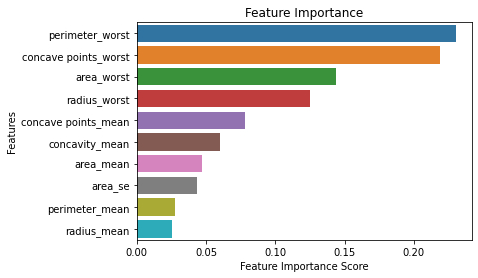

In [21]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importance")
plt.show()